## Audio descriptors and segmentation

In this notebook we are going to look at audio descriptors that are relativelyt popular in scientific papers dealing with voice / gender recognition. Majority of features, short of pitch, have been retrieved through Yaafe: http://yaafe.sourceforge.net/features.html

In [1]:
import logging
import numpy as np
import pandas as pd
import yaafelib
import librosa
import aubio
import matplotlib.pyplot as plt
import dsp

%matplotlib inline  

Description of the *featurespecs* can be found on the web page

In [5]:
featurespecs = \
    ['LSF: LSF blockSize={} stepSize={}',
     'SpectralDecrease: SpectralDecrease blockSize={} stepSize={}',
     'SpectralFlatness: SpectralFlatness blockSize={} stepSize={}',
     'SpectralFlux: SpectralFlux blockSize={} stepSize={}',
     'SpectralSlope: SpectralSlope blockSize={} stepSize={}',
     'SpectralRolloff: SpectralRolloff blockSize={} stepSize={}',
     'SpectralShapeStatistics: SpectralShapeStatistics blockSize={} stepSize={}',
     'MFCC: MFCC blockSize={} stepSize={}',
     'SpectralVariation: SpectralVariation blockSize={} stepSize={}']
    
path = '/home/tracek/Data/gender/Voxforge/ablackball-20121113-vvk/wav/a0333.wav'

find_salient = False
sr = 16000
block_size = 1024
nfft = 512

### Segmentation
Since we are going to aggregate numbers, it is important that we run calculations over actual voice. Non-voice regions of audio samples, typically in the beginning and end of a recording, are the regions where speaker has either not speaking yet or has finished speaking already. These regions are not necessarily silent: they can contain various types of noise, like white noise, background noise, electronic noise etc. Not removing them severely affects features that can be extracted from the audio. Let’s take as an example MFCC: Mel-frequency cepstral coefficients (https://en.wikipedia.org/wiki/Mel-frequency_cepstrum)

In [26]:
def get_onsets(signal, sr, nfft, hop, onset_detector_type='hfc', onset_threshold=0.01):
    onsets = []

    onset_detector = aubio.onset(onset_detector_type, nfft, hop, sr)
    onset_detector.set_threshold(onset_threshold)

    signal_windowed = np.array_split(signal, np.arange(hop, len(signal), hop))

    for frame in signal_windowed[:-1]:
        if onset_detector(frame):
            onsets.append(onset_detector.get_last())
    return np.array(onsets[1:])

def get_start_end_samples(y, sr, nfft, hop,  onset_detector_type='hfc', onset_threshold=0.01):
    onsets_fw = get_onsets(y, sr, nfft, hop, onset_detector_type, onset_threshold)
    onsets_bw = get_onsets(y[::-1], sr, nfft, hop, onset_detector_type, onset_threshold)
    onsets_bw_rev = (len(y) - np.array(onsets_bw)[::-1])
    return onsets_fw[0], onsets_bw_rev[-1]


def get_salient_region(y, sr, start, end, start_buffer=0.0, end_buffer=0.0):
    salient_start = max(0, start - int(start_buffer * sr))
    salient_end = min(len(y), end + int(end_buffer * sr))
    return y[salient_start:salient_end]

def plot_feature(feature, y_len):
    x_spacing = np.linspace(0, y_len, len(feature))

    no_figures = feature.shape[1]
    if no_figures == 1:
        plt.figure(figsize=(15,5))
        plt.plot(x_spacing, feature)
    else:
        f, ax = plt.subplots(no_figures, 1, sharex=True, figsize=(15,15))
        for idx in range(no_figures):
            ax[idx].plot(x_spacing, feature[:, idx])
    plt.xlabel('time')

In [27]:
feature_plan = yaafelib.FeaturePlan(sample_rate=sr, normalize=True)
for featurespec in featurespecs:
    feature = featurespec.format(block_size, block_size // 2)
    assert feature_plan.addFeature(feature), 'Failed to load %s feature' % feature
    logging.info('Feature %s loaded', feature)
    
engine = yaafelib.Engine()
engine.load(feature_plan.getDataFlow())

True

In [28]:
y, sr = librosa.load(path, sr=sr)
y = librosa.util.normalize(y)
if find_salient:
    y_start, y_end = get_start_end_samples(y.astype('float32'), sr, nfft=nfft, hop=nfft // 2)
    y = get_salient_region(y, sr, start=y_start, end=y_end, start_buffer=0.2, end_buffer=0.4)

In [29]:
feats = engine.processAudio(y.reshape(1, -1))
x_shape_expected = next(iter(feats.values())).shape[0] # random item
for name, feat in feats.items():
    if feat.shape[0] != x_shape_expected:
        print('Feature {} is messed up. Expected {} got {}'.format(name, x_shape_expected, feat.shape[0]))

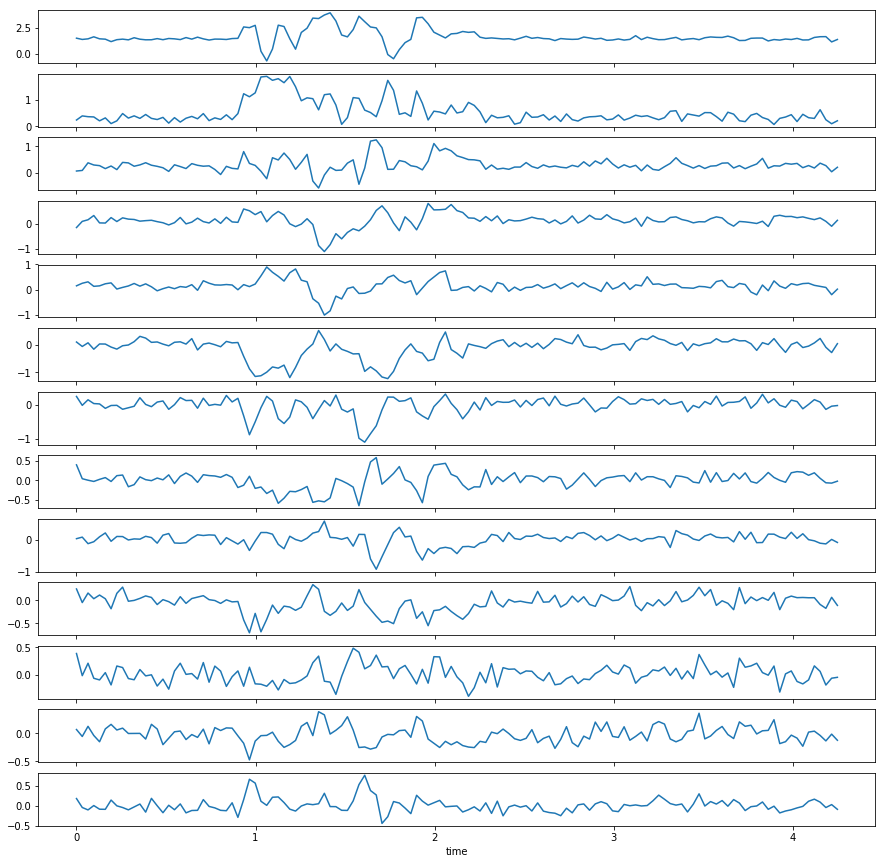

In [30]:
plot_feature(feats['MFCC'], len(y) / sr)

It is clear from visual inspection that MFCC has high variance with human voice and low outside. Taking simple mean or median would severely distort the result. 

In [31]:
y_start, y_end = get_start_end_samples(y.astype('float32'), sr, nfft=nfft, hop=nfft // 2)
print('Start: ', y_start / sr)
print('End: ', y_end / sr)

Start:  0.94575
End:  1.91875


Text(0,0.5,'amplitude')

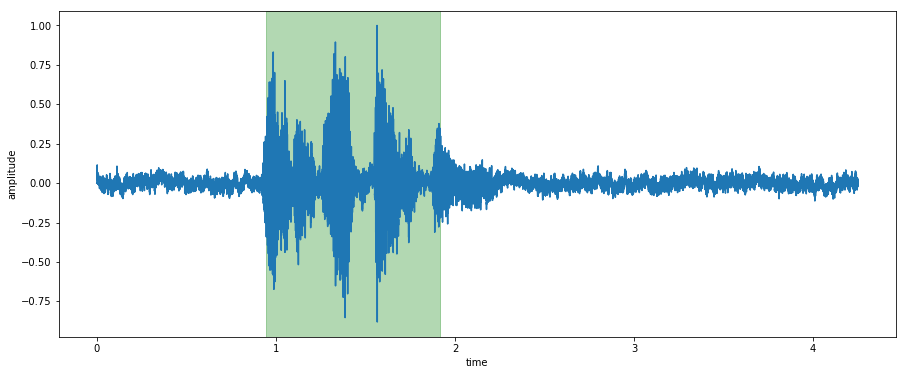

In [42]:
plt.figure(figsize=(15,6))
plt.plot(np.linspace(0, len(y)/sr, len(y)), y)
plt.axvspan(xmin=y_start / sr, xmax=y_end / sr, color='green', alpha=0.3)
plt.xlabel('time')
plt.ylabel('amplitude')

## Beauty! 
Our onset detectors did a good job. Add some margin and we're good

In [43]:
y = get_salient_region(y, sr, start=y_start, end=y_end, start_buffer=0.2, end_buffer=0.4)

Text(0,0.5,'amplitude')

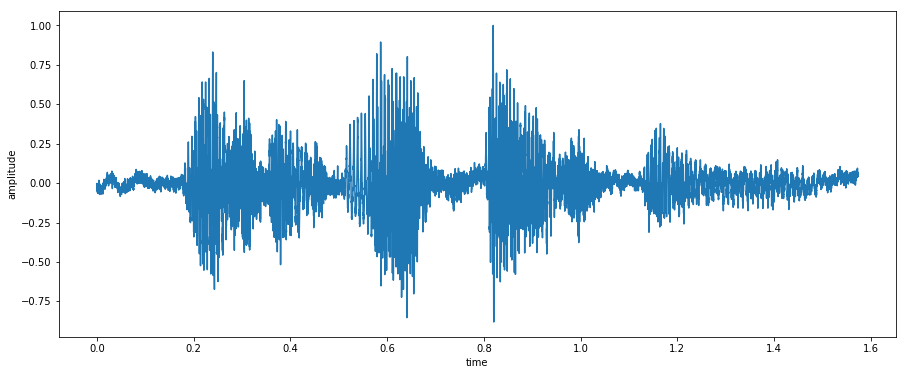

In [45]:
plt.figure(figsize=(15,6))
plt.plot(np.linspace(0, len(y)/sr, len(y)), y)
plt.xlabel('time')
plt.ylabel('amplitude')